In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from datetime import datetime
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

start = time.perf_counter()

### Functions for Results

In [46]:
def med(df, col, deci=None):
    median = round(df[col].median(),deci)
    return median

def avg(df, col, deci=None):
    average = round(df[col].mean(), deci)
    return average

def max(df, col, deci=None):
    maximum = round(df[col].max(),deci)
    return maximum

def sum(df, col, deci=None):
    total = round(df[col].sum(),deci)
    return total

def midp(df, col):
    midpoint = (df[col].max() + df[col].min()) / 2
    return midpoint

def rolla(df, col, windw):
    rolling_average = df[col].rolling(window=windw).mean()
    return rolling_average

def rnd(val, deci):
    new = round(val, deci)
    return new

Only counting activities post Europe, export HeartWatch Workouts from Jul 17 - Today and add the csv to the wd

In [47]:
df = pd.read_csv('HeartWatch-Workouts-20230717-to-20240609.csv')

In [48]:
df = df.drop(['Date', 'from', 'to', 'rpe', 'Load', 'bpm-lo', 'bpm-90%+-%', '90%+-mins',
              'bpm-80-90%-%', '80-90%-mins','bpm-70-80%-%', '70-80%-mins','bpm-60-70%-%',
              '60-70%-mins','bpm-50-60%-%', '50-60%-mins'], axis=1)

# Drop Run w/ Bear
df = df.drop(19)
df.tail()

,ISO,Duration,Type,bpm-Avg.,bpm-%,bpm-hi,Cals,Cals/h,km,km/h,/km
65,2023-11-16T14:02:52-05:00,02:40:03,Cycling,148.1,77.3,169.5,620.2,232.5,21.34,8.0,00:07:30
66,2023-11-18T13:12:11-05:00,01:22:48,Cycling,127.2,66.4,146.5,327.0,236.9,18.52,13.4,00:04:28
67,2023-12-05T13:19:36-05:00,00:55:07,Walking,108.4,56.6,117.4,225.8,245.7,3.89,4.2,00:14:10
68,2024-05-18T13:37:52-04:00,02:55:02,Cycling,107.9,56.3,166.0,341.8,117.2,22.69,7.8,00:07:42
69,2024-05-25T14:40:57-04:00,03:32:06,Golf,97.8,51.0,129.0,418.8,118.5,3.88,1.1,00:54:36


In [49]:
df['ISO'] = pd.to_datetime(df['ISO'],utc=True)
print(df['ISO'].dtypes)

datetime64[ns, UTC]


In [50]:
# Fix Datetime Columns

df['Duration'] = pd.to_timedelta(df['Duration'])
df['/km'] = pd.to_timedelta(df['/km'])
df['Date'] = df['ISO'].dt.date
df['weeknum'] = df['ISO'].dt.week


df.set_index('ISO', inplace=True) 

wklySUM = pd.DataFrame(df[df['Type'] == 'Running'].groupby(pd.Grouper(freq='W-SUN')).agg('sum'))
wklyAVG = pd.DataFrame(df[df['Type'] == 'Running'].groupby(pd.Grouper(freq='W-SUN')).agg('mean'))

# print(wklySUM.head())
# print(wklyAVG.head())

In [51]:
dfRun = df[df['Type'] == 'Running']
dfBike = df[df['Type'] == 'Cycling']
dfWalk = df[df['Type'] == 'Walking']
dfOther = df[~df['Type'].isin(['Running', 'Cycling', 'Walking'])]

# print(dfRun.info())
# print(dfBike.info())
# print(dfWalk.info())
# print(dfOther.head())

In [52]:
# Pace Calculation
# Calculate the total seconds of Duration column
total_seconds = dfRun['Duration'].dt.total_seconds()
dfBike['Duration'] = dfBike['Duration'].apply(lambda x: x.total_seconds() / 3600)

# Average Pace from M/S
mps = dfRun['km'].sum()*1000 / total_seconds.sum()
kph = mps * 3.6
mpk = 60 / kph

integer_part = int(mpk)
decimal_part = mpk - integer_part

# Convert decimal part to minutes by dividing by 60
decimal_minutes = round(decimal_part * 60,0)

In [53]:
# Weighted HR
dfRunWght = dfRun

# Convert the time delta to decimal hours and create a new column
dfRunWght["Duration"] = dfRunWght["Duration"].apply(lambda x: x.total_seconds() / 3600)
dfRunWght['Weighted HR'] = dfRunWght['Duration'] * dfRunWght['bpm-Avg.']

# HR/Speed Decimal
dfRun['HR/Speed'] = (dfRun['bpm-Avg.'] / dfRun['km/h']) 

# Cumulative Sum
dfRun['CumKM'] = dfRun['km'].cumsum()

# Minute Duration 
dfRun['mDuration'] = 60 * dfRun['Duration']
dfBike['mDuration'] = 60 * dfBike['Duration']

In [54]:
dfRun.tail()
dfRun.to_csv('runStats.csv')
dfBike.to_csv('bikeStats.csv')

## Graphs

### Running Distance Frequency 

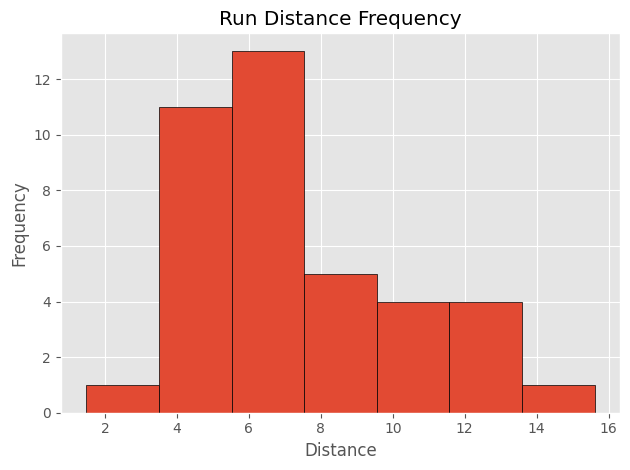

In [55]:
plt.hist(dfRun['km'], bins='auto', edgecolor='black')
plt.title('Run Distance Frequency')
plt.xlabel('Distance')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('Graphs/Distance Frequency.png', dpi=600)
plt.show()

### Average Heart Rate Frequency

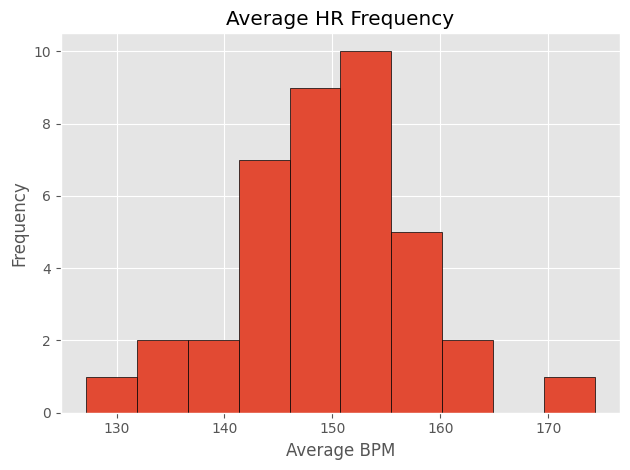

In [56]:
plt.hist(dfRun['bpm-Avg.'], bins="auto", edgecolor='black')
plt.title('Average HR Frequency')
plt.xlabel('Average BPM')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('Graphs/HR Frequency.png', dpi=600)
plt.show()

### Average Heart Rate versus Average Speed (km/h)

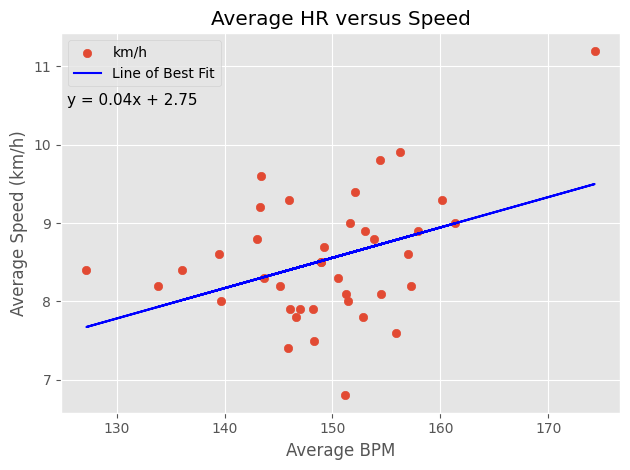

In [57]:
# Line of Best Fit
# Fit a linear regression line to the data
degree = 1
coefficients = np.polyfit(dfRun['bpm-Avg.'], dfRun['km/h'], degree)
slope = coefficients[0]
intercept = coefficients[1]
# Calculate the predicted y-values using the line equation
predicted_y = slope * dfRun['bpm-Avg.'] + intercept
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# Plot
plt.scatter('bpm-Avg.', 'km/h', data=dfRun)
plt.plot(dfRun['bpm-Avg.'], predicted_y, color='blue', label='Line of Best Fit')
plt.xlabel('Average BPM')
plt.ylabel('Average Speed (km/h)')
plt.title('Average HR versus Speed')
plt.text(0.01, 0.81, equation, fontsize=11, transform=plt.gca().transAxes)
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('Graphs/SpeedvsHR.png', dpi=600)
plt.show()

### Heart Rate / Speed over Time

Lower is better

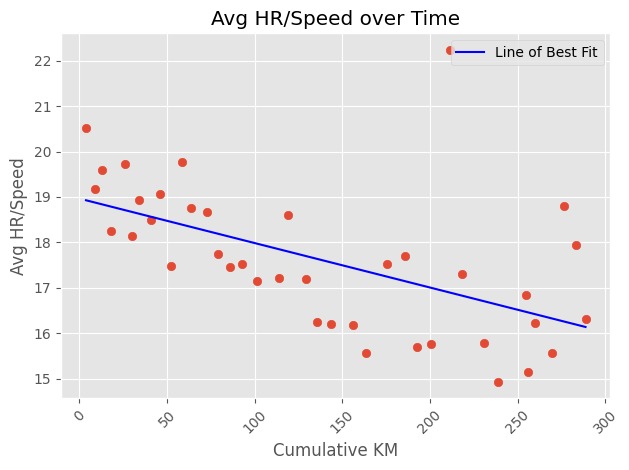

In [58]:
degree1 = 1
coefficients1 = np.polyfit(dfRun['CumKM'], dfRun['HR/Speed'], degree)
slope1 = coefficients1[0]
intercept1 = coefficients1[1]
# Calculate the predicted y-values using the line equation
predicted_y1 = slope1 * dfRun['CumKM'] + intercept1
equation1 = f'y = {slope1:.2f}x + {intercept1:.1f}'

plt.scatter(dfRun['CumKM'], y= dfRun['HR/Speed'])
plt.plot(dfRun['CumKM'], predicted_y1, color='blue', label='Line of Best Fit')
# plt.text(0.75, 0.86, equation1, fontsize=10, transform=plt.gca().transAxes)
plt.xlabel('Cumulative KM')
plt.xticks(rotation=45)
plt.ylabel('Avg HR/Speed')
plt.title('Avg HR/Speed over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('Graphs/HR-Speed over Time.png', dpi=600)
plt.show()

### Weekly Distance


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


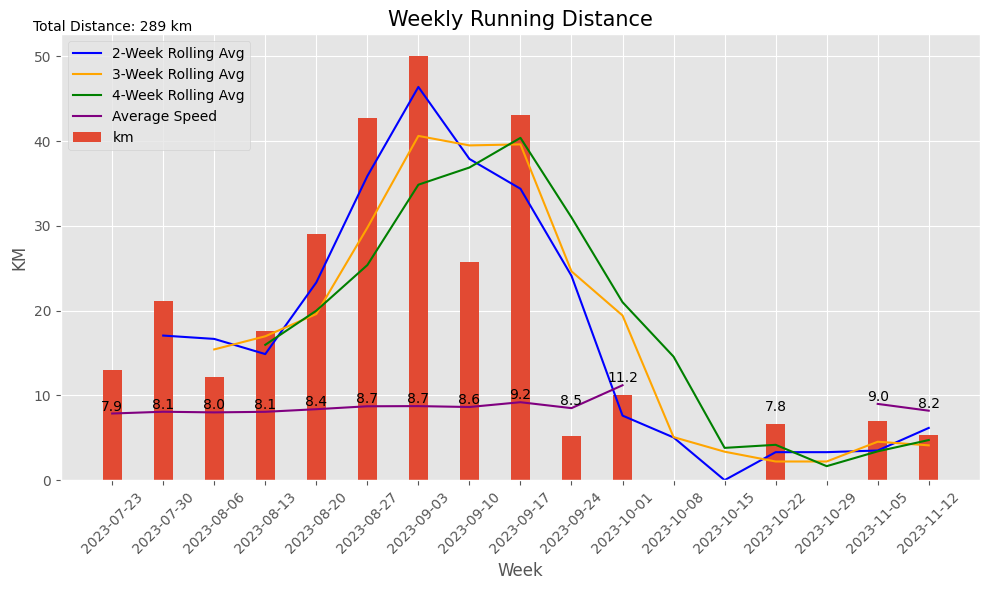

In [59]:
plt.figure(figsize=(10,6))

# Rolling Average 
rolling_average2 = rolla(wklySUM, 'km', 2)
plt.plot(wklySUM.index, rolling_average2, label='2-Week Rolling Avg', color='blue')
rolling_average3 = rolla(wklySUM, 'km', 3)
plt.plot(wklySUM.index, rolling_average3, label='3-Week Rolling Avg', color='orange')
rolling_average4 = rolla(wklySUM, 'km', 4)
plt.plot(wklySUM.index, rolling_average4, label='4-Week Rolling Avg', color='green')

# Average Speed Line
plt.plot(wklyAVG.index, wklyAVG['km/h'], label='Average Speed', color='purple')
for idx, value in enumerate(wklyAVG['km/h']):
        plt.text(wklyAVG.index[idx], wklyAVG['km/h'][idx], f'{value:.1f}', ha='center', va='bottom',
        fontsize=10, color='black')

# Toal Distance Text
total_distance = sum(wklySUM, 'km')
plt.text(wklySUM.index[0], wklySUM['km'].max() + 2.5, f'Total Distance: {total_distance:.0f} km',
        ha='center', va='bottom', fontsize=10, color='black', transform=plt.gca().transData)

plt.bar(wklySUM.index, wklySUM['km'], label='km', width=2.6)
# for idx, value in enumerate(wklySUM['km']):
#         plt.text(wklySUM.index[idx], 0, f'{value:.1f}', ha='center', va='bottom',
#         fontsize=10, color='black')

plt.xlabel('Week')
plt.ylabel('KM')
plt.title('Weekly Running Distance', fontsize=15)
plt.legend(loc='upper left')
plt.xticks(wklySUM.index, wklySUM.index.strftime('%Y-%m-%d'), rotation=45)
plt.tight_layout()
# plt.savefig('Graphs/Weekly Distance.png', dpi=600)
plt.show()

### Cumulative Distance

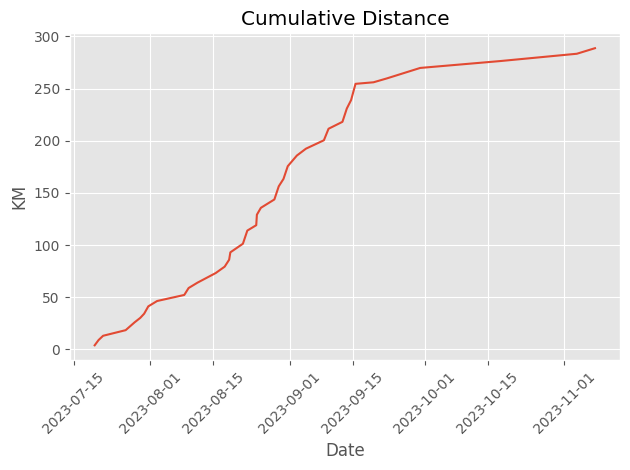

In [60]:
plt.plot(dfRun.index, dfRun['CumKM'])
plt.title('Cumulative Distance')
plt.xlabel('Date')
plt.ylabel('KM')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('Graphs/Cumulative Distance.png', dpi=600)
plt.show()

### Speed over Time

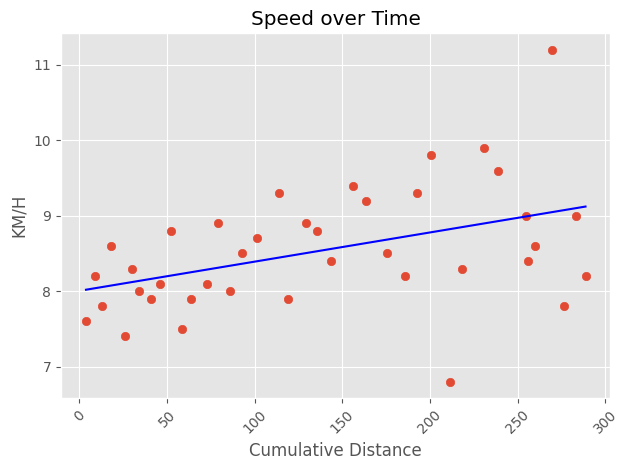

In [61]:
degree2 = 1
coefficients2 = np.polyfit(dfRun['CumKM'], dfRun['km/h'], degree2)
slope2 = coefficients2[0]
intercept2 = coefficients2[1]
# Calculate the predicted y-values using the line equation
predicted_y2 = slope2 * dfRun['CumKM'] + intercept2
equation1 = f'y = {slope2:.2f}x + {intercept2:.1f}'

plt.scatter(dfRun['CumKM'], dfRun['km/h'])
plt.plot(dfRun['CumKM'], predicted_y2, color='blue', label='Line of Best Fit')
plt.title('Speed over Time')
plt.xlabel('Cumulative Distance')
plt.ylabel('KM/H')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('Graphs/Speed over Time.png', dpi=600)
plt.show()

### Running Boxplots

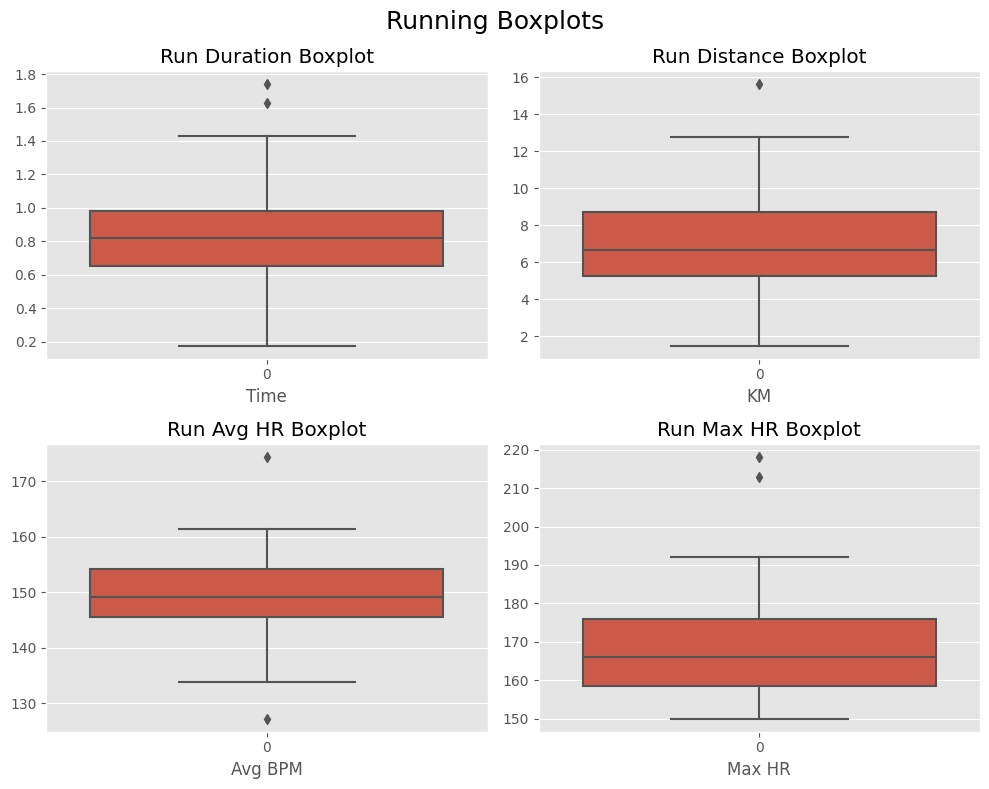

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Run Duration Boxplot
sns.boxplot(dfRun['Duration'], ax=axes[0, 0])
axes[0, 0].set_title('Run Duration Boxplot')
axes[0, 0].set_xlabel('Time')
# Run Distance Boxplot
sns.boxplot(dfRun['km'], ax=axes[0, 1])
axes[0, 1].set_title('Run Distance Boxplot')
axes[0, 1].set_xlabel('KM')
# Run Average HR Boxplot
sns.boxplot(dfRun['bpm-Avg.'], ax=axes[1, 0])
axes[1, 0].set_title('Run Avg HR Boxplot')
axes[1, 0].set_xlabel('Avg BPM')
# Run Max HR Boxplot
sns.boxplot(dfRun['bpm-hi'], ax=axes[1, 1])
axes[1, 1].set_title('Run Max HR Boxplot')
axes[1, 1].set_xlabel('Max HR')

fig.suptitle('Running Boxplots', fontsize=18)

plt.tight_layout()
# plt.savefig('Graphs/Run Boxplots.png', dpi=600)
plt.show()

In [84]:
dfRB = df[df['Type'] == 'Running']
dfRB_pivot = dfRB.pivot_table(index='weeknum', aggfunc={'bpm-Avg.': 'mean', 'Cals': 'sum',
                                                            'km': 'sum', 'Duration': 'sum', 'km/h': 'mean'},
                                fill_value={'bpm-Avg.': 0, 'Cals': 0, 'km': 0, 'Duration': pd.NaT, 'km/h': 0})
round(dfRB_pivot,2)


,Cals,Duration,bpm-Avg.,km,km/h
weeknum,,,,,
29,991.3,0 days 01:38:31,155.33,12.95,7.87
30,1690.0,0 days 02:38:52,151.20,21.18,8.07
31,1026.1,0 days 01:31:13,150.30,12.16,8.00
32,1468.4,0 days 02:12:03,150.13,17.60,8.07
33,2434.1,0 days 03:28:56,149.45,29.07,8.38
34,3521.2,0 days 04:51:02,150.48,42.70,8.72
35,4120.8,0 days 05:45:12,145.10,50.11,8.74
36,2124.4,0 days 03:09:38,150.53,25.71,8.63
37,3212.5,0 days 04:39:18,148.75,43.07,9.20


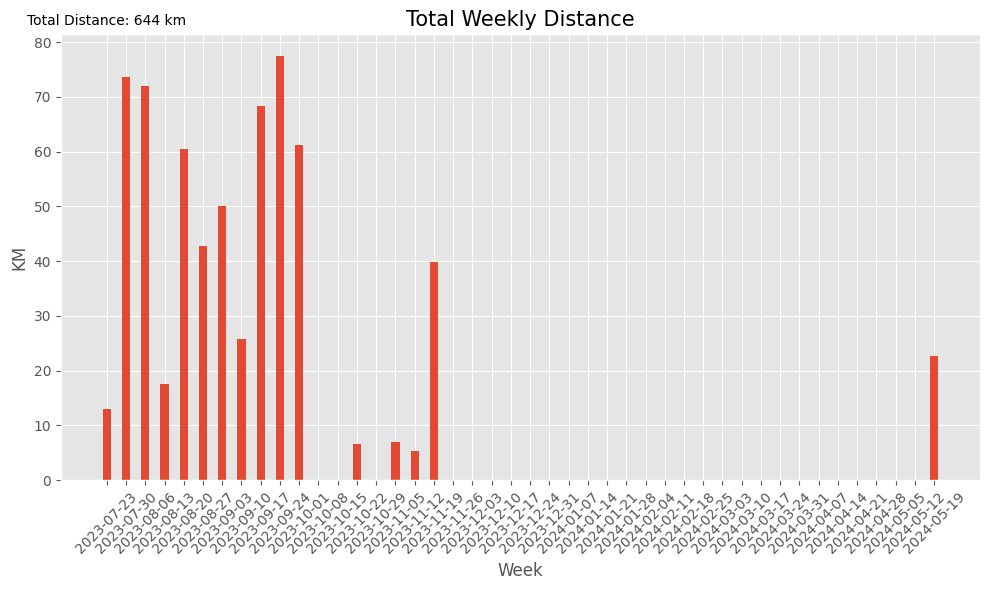

In [64]:
plt.figure(figsize=(10,6))

dfRB = df[(df['Type'] == 'Running') | (df['Type'] == 'Cycling')]

wklyRBSum = pd.DataFrame(dfRB.groupby(pd.Grouper(freq='W-SUN'))['km'].sum())

# Toal Distance Text
total_distance = sum(wklyRBSum, 'km')
plt.text(wklyRBSum.index[0], wklyRBSum['km'].max() + 5, f'Total Distance: {total_distance:.0f} km',
        ha='center', va='bottom', fontsize=10, color='black', transform=plt.gca().transData)

plt.bar(wklyRBSum.index, wklyRBSum['km'], width=3)
# for idx, value in enumerate(wklyRBSum['km']):
#         plt.text(wklyRBSum.index[idx], 0, f'{value:.1f}', ha='center', va='bottom',
#         fontsize=10, color='black')

plt.xlabel('Week')
plt.ylabel('KM')
plt.title('Total Weekly Distance', fontsize=15)
plt.xticks(wklyRBSum.index, wklyRBSum.index.strftime('%Y-%m-%d'), rotation=45)
plt.tight_layout()
# plt.savefig('Graphs/Total Weekly.png', dpi=600)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Graphs/Total Weekly.png'

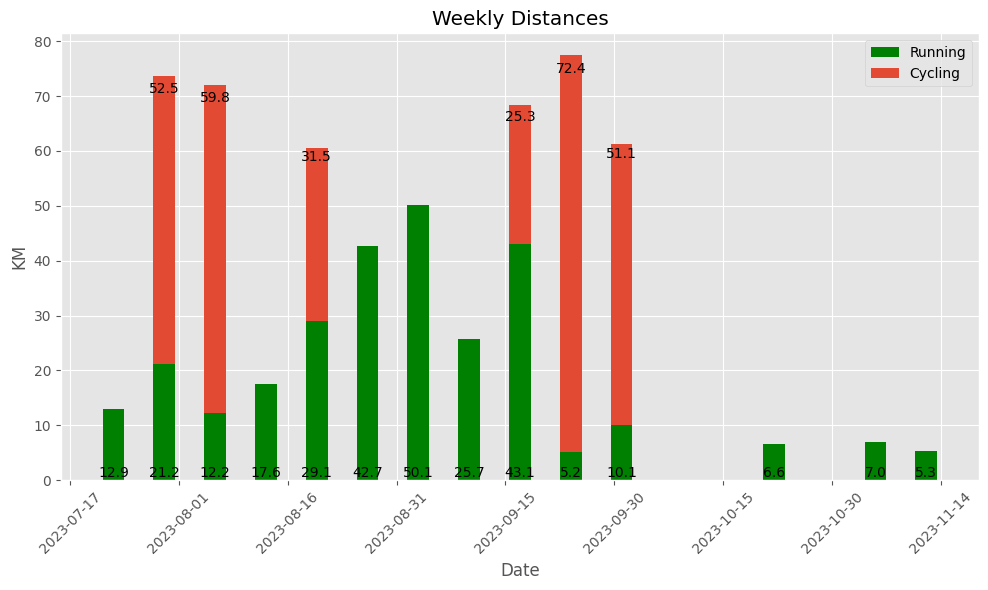

In [65]:
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'wklyRBSum'
plt.figure(figsize=(10, 6))

wklyRBSum = pd.DataFrame(dfRB.groupby(['Type', pd.Grouper(freq='W-SUN')])['km'].sum())
wklyRBSum.sort_index(inplace=True)


# Assuming you have a DataFrame 'wklyRBSum' with columns 'Type' and 'km'
# and you want to plot the weekly sums for 'Running' and 'Cycling'
running_data = wklyRBSum.loc['Running']
cycling_data = wklyRBSum.loc['Cycling']

# Resample both datasets to have the same date index
cycling_data = cycling_data.reindex(running_data.index, fill_value=0)

# Create a stacked bar chart
plt.bar(running_data.index, running_data['km'], label='Running', width=3, color='green')
plt.bar(cycling_data.index, cycling_data['km'], label='Cycling', bottom=running_data['km'], width=3)


for idx, value in enumerate(running_data['km']):
        if value != 0:
                plt.text(running_data.index[idx], 0, f'{value:.1f}', ha='center', va='bottom',
                fontsize=10, color='black')

for idxx, valuee in enumerate(cycling_data['km']):
        top = cycling_data['km'][idxx] + running_data['km'][idxx]
        if valuee != 0:
            plt.text(cycling_data.index[idxx], top*0.95,
                  f'{valuee:.1f}', ha='center', va='bottom',
                 fontsize=10, color='black')



# Customize the plot (e.g., labels, title, legend, etc.)
plt.xlabel('Date')
# Show every n-th date
n = 1  # Change this value as needed
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
plt.gca().set_xticks(plt.gca().get_xticks()[::n])

plt.ylabel('KM')
plt.title('Weekly Distances')
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('Graphs/Total Weekly.png', dpi=600)
plt.show()

In [ ]:
sum_piv = df.pivot_table(values='km', columns=df.index.month, aggfunc='sum', index='Type',
                         fill_value=0)
print(sum_piv)

ISO         7       8       9   11
Type                              
Cycling  77.27   66.53  148.79   0
Golf      4.50    0.00    0.00   0
Running  41.17  134.40   94.22   7
Walking   0.00   35.85    5.16   0


In [ ]:
# Duration
avg_wght_hr = round(dfRunWght['Weighted HR'].sum() / dfRunWght['Duration'].sum(),2)
avg_dur = dfRun['Duration'].mean()
tot_dur = dfRun['Duration'].sum()
max_dur = dfRun['Duration'].max()

# Count Runs
num_runs = dfRun['km'].count()
num_rides = dfBike['km'].count()
num_walks = dfWalk['km'].count()
new_run = dfRun['Date'][-1]
new_ride = dfBike['Date'][-1]
new_walk = dfWalk['Date'][-1]

avghr_u155 = dfRun[dfRun['bpm-Avg.'] < 155].count()['bpm-Avg.']
pavghr_u155 = round(avghr_u155 / num_runs *100,2)
avghr_u150 = dfRun[dfRun['bpm-Avg.'] < 150].count()['bpm-Avg.']
pavghr_u150 = round(avghr_u150 / num_runs *100,2)

ovr_5k = dfRun[dfRun['km'] >=5].count()['km']
povr_5k = round(ovr_5k / num_runs *100,2)
ovr_10k = dfRun[dfRun['km'] >=10].count()['km']
povr_10k = round(ovr_10k / num_runs *100,2)
runs_per_day = round(num_runs / dfRun['Date'].nunique(),3)
date_cts = dfRun['Date'].value_counts()
dbl_days = date_cts[date_cts > 1].count()

# Durations to Time Format
avg_dur_h = int(avg_dur)
max_dur_h = int(max_dur)
tot_dur_h = int(tot_dur)

avg_dur_m_dec = (avg_dur - avg_dur_h)*60
max_dur_m_dec = (max_dur - max_dur_h)*60
tot_dur_m_dec = (tot_dur - tot_dur_h)*60

avg_dur_m = int(avg_dur_m_dec)
max_dur_m = int(max_dur_m_dec)
tot_dur_m = int(tot_dur_m_dec)

avg_dur_s = int((avg_dur_m_dec - avg_dur_m)*60)
max_dur_s = int((max_dur_m_dec - max_dur_m)*60)
tot_dur_s = int((tot_dur_m_dec - tot_dur_m)*60)

avg_dur_f = str(avg_dur_h) + ':' + str(avg_dur_m) + ':' + str(avg_dur_s)
max_dur_f = str(max_dur_h) + ':' + str(max_dur_m) + ':' + str(max_dur_s)
tot_dur_f = str(tot_dur_h) + ':' + str(tot_dur_m) + ':' + str(tot_dur_s)

## Running Stats

In [ ]:
print(f'Most Recent Run: {new_run}')
print('----------------------------')
print(f'Runs: {num_runs}')
print(f'Runs > 5k(%): {ovr_5k} ({povr_5k}%)')
print(f'Runs > 10k(%): {ovr_10k} ({povr_10k}%)')
print(f'Runs < 155bpm(%): {avghr_u155} ({pavghr_u155}%)')
print(f'Runs < 150bpm(%): {avghr_u150} ({pavghr_u150}%)')
print(f'Double Days: {dbl_days}')
print(f'Runs per Day: {runs_per_day}')

print('----------------------------')
print(f'Average Duration: {avg_dur_f}')
print(f'Average Distance: {avg(dfRun, "km",2)}')
print(f"Average Pace: {integer_part}:{decimal_minutes}")
print(f'Average Speed: {avg(dfRun, "km/h",2)}')
print(f'Average Weighted HR: {avg_wght_hr}')
print(f'Average HR: {avg(dfRun, "bpm-Avg.",2)}')
print(f'Average Max HR: {avg(dfRun, "bpm-hi",2)}')
print(f'Average Calories: {avg(dfRun, "Cals",)}')

print('----------------------------')
print(f'Median Distance: {med(dfRun, "km", 2)}')
print(f'Median Avg HR: {med(dfRun, "bpm-Avg.", 2)}')
print(f'Median Max HR: {med(dfRun, "bpm-hi", 2)}')
print(f'Median Calories: {med(dfRun, "Cals",)}')

print('----------------------------')
print(f'Max Duration: {max_dur_f}')
print(f'Max Distance: {max(dfRun, "km",2)}')
print(f'Max Average HR: {max(dfRun, "bpm-Avg.",2)}')
print(f'Max Max HR: {max(dfRun, "bpm-hi", 2)}')
print(f'Max Calories: {max(dfRun, "Cals",)}')

print('----------------------------')
print(f'Total Duration: {tot_dur_f}')
print(f'Total Distance: {sum(dfRun, "km", 2)}')
print(f'Total Running Calories: {sum(dfRun, "Cals",)}')

Most Recent Run: 2023-11-03
----------------------------
Runs: 37
Runs > 5k(%): 31 (83.78%)
Runs > 10k(%): 9 (24.32%)
Runs < 155bpm(%): 29 (78.38%)
Runs < 150bpm(%): 18 (48.65%)
Double Days: 2
Runs per Day: 1.057
----------------------------
Average Duration: 0:52:12
Average Distance: 7.48
Average Pace: 6:59.0
Average Speed: 8.56
Average Weighted HR: 150.56
Average HR: 149.91
Average Max HR: 170.68
Average Calories: 598
----------------------------
Median Distance: 7.0
Median Avg HR: 150.5
Median Max HR: 168.0
Median Calories: 554
----------------------------
Max Duration: 1:44:17
Max Distance: 15.61
Max Average HR: 174.3
Max Max HR: 218.0
Max Calories: 1149
----------------------------
Total Duration: 32:11:42
Total Distance: 276.79
Total Running Calories: 22140


## Riding/Walking Stats

In [ ]:
print(f'Most Recent Ride: {new_ride}')
print(f'Rides: {num_rides}')
print(f'Average Distance: {avg(dfBike, "km", 2)}')
print(f'Average HR: {avg(dfBike, "bpm-Avg.", 2)}')
print(f'Average Max HR: {avg(dfBike, "bpm-hi", 2)}')
print(f'Average Calories: {avg(dfBike, "Cals",)}')
print(f'Average Speed: {avg(dfBike, "km/h", 2)}')
print(f'Median Distance: {med(dfBike, "km", 2)}')
print(f'Median Avg HR: {med(dfBike, "bpm-Avg.", 2)}')
print(f'Median Max HR: {med(dfBike, "bpm-hi", 2)}')
print(f'Median Calories: {med(dfBike, "Cals",)}')
print(f'Median Speed: {med(dfBike, "km/h", 2)}')
print('----------------------------')
print(f'Most Recent Walk: {new_walk}')
print(f'Walks: {num_walks}')
print(f'Average Distance: {avg(dfWalk, "km", 2)}')
print(f'Average HR: {avg(dfWalk, "bpm-Avg.", 2)}')
print(f'Average Max HR: {avg(dfWalk, "bpm-hi", 2)}')
print(f'Average Calories: {avg(dfWalk, "Cals",)}')
print(f'Median Distance: {med(dfWalk, "km", 2)}')
print(f'Median Avg HR: {med(dfWalk, "bpm-Avg.", 2)}')
print(f'Median Max HR: {med(dfWalk, "bpm-hi", 2)}')
print(f'Median Calories: {med(dfWalk, "Cals",)}')
print('----------------------------')
print('Maximums')
print(f'Max Bike Distance: {max(dfBike, "km", 2)}')
print(f'Max Bike Calories: {max(dfBike, "Cals",)}')
print(f'Max Walk Distance: {max(dfWalk, "km", 2)}')
print(f'Max Walk Calories: {max(dfWalk, "Cals",)}')
print('----------------------------')
print("Totals")
print(f'Total Bike Distance: {sum(dfBike, "km", 2)}')
print(f'Total Bike Calories: {sum(dfBike, "Cals",)}')
print(f'Total Walk Distance: {sum(dfWalk, "km", 2)}')
print(f'Total Walk Calories: {sum(dfWalk, "Cals",)}')
print('----------------------------')
print(f'Runtime: {round(time.perf_counter() - start,2)}s')


Most Recent Ride: 2023-09-28
Rides: 10
Average Distance: 29.26
Average HR: 145.11
Average Max HR: 180.7
Average Calories: 674
Average Speed: 18.68
Median Distance: 32.2
Median Avg HR: 144.1
Median Max HR: 183.0
Median Calories: 688
Median Speed: 20.05
----------------------------
Most Recent Walk: 2023-09-22
Walks: 11
Average Distance: 3.73
Average HR: 111.3
Average Max HR: 131.45
Average Calories: 221
Median Distance: 3.83
Median Avg HR: 113.3
Median Max HR: 129.0
Median Calories: 208
----------------------------
Maximums
Max Bike Distance: 37.65
Max Bike Calories: 1012
Max Walk Distance: 6.42
Max Walk Calories: 406
----------------------------
Totals
Total Bike Distance: 292.59
Total Bike Calories: 6740
Total Walk Distance: 41.01
Total Walk Calories: 2434
----------------------------
Runtime: 9.47s
